# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [88]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [89]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [90]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [91]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


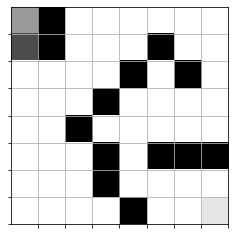

In [92]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [93]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [94]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [95]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [96]:
import random
import numpy as np

def qtrain(model, maze, **opt):
    n_epoch = opt.get('epochs', 1000)
    max_memory = opt.get('max_memory', maze.size * 8)
    data_size = opt.get('data_size', 32)
    gamma = opt.get('gamma', 0.9)  # Discount factor for future rewards

    # Initialize the Q memory and environment
    qmaze = TreasureMaze(maze)
    memory = []  # List to store agent experiences
    start_time = datetime.datetime.now()

    for epoch in range(n_epoch):
        agent_cell = get_random_free_cell(maze)  # Choose a random free cell as the starting position
        qmaze.reset(agent_cell)
        game_over = False

        while not game_over:
            # Observe the current state
            current_state = qmaze.observe()

            # Choose an action based on the current state
            q_values = model.predict(current_state)[0]
            if np.random.rand() < epsilon:
                action = random.randint(0, num_actions - 1)
            else:
                action = np.argmax(q_values)

            # Apply the action and get the new state and reward
            envstate, reward, status = qmaze.act(action)

            # Check if the game is over
            if status != 'not_over':
                game_over = True

            # Store the experience in memory
            memory.append((current_state, action, reward, envstate, game_over))

            # Train the model with a random batch of experiences
            if len(memory) >= data_size:
                batch = random.sample(memory, data_size)
                inputs = np.zeros((data_size, maze.size))
                targets = np.zeros((data_size, num_actions))
                for i, (state, action, reward, next_state, game_over) in enumerate(batch):
                    inputs[i] = state
                    targets[i] = model.predict(state)[0]
                    targets[i, action] = reward
                    if not game_over:
                        targets[i, action] += gamma * np.max(model.predict(next_state)[0])
                model.fit(inputs, targets, epochs=1, verbose=0)

        # Print the progress
        dt = datetime.datetime.now() - start_time
        template = "Epoch {}/{}, Loss: {}, Exploration: {:.4f}, Duration: {}"
        print(template.format(epoch + 1, n_epoch, model.loss, epsilon, dt))

def get_random_free_cell(maze):
    free_cells = []
    for row in range(len(maze)):
        for col in range(len(maze[0])):
            if maze[row, col] == 1.0:
                free_cells.append((row, col))
    return random.choice(free_cells)



## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

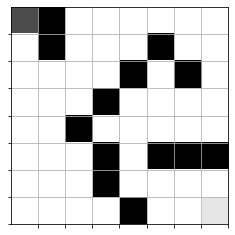

In [97]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [98]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

Epoch 1/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:12.270692
Epoch 2/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:12.367930
Epoch 3/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:12.426197
Epoch 4/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:12.956485
Epoch 5/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:13.403283
Epoch 6/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:14.472123
Epoch 7/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:14.941200
Epoch 8/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:15.020305
Epoch 9/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:15.937802
Epoch 10/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:16.495929
Epoch 11/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:16.631388
Epoch 12/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:17.999973
Epoch 13/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:20.135466
Epoch 14/1000, Loss: mse, Exploration: 0.1000, Duration: 0:00:22.358678
E

Epoch 115/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:44.027779
Epoch 116/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:44.092875
Epoch 117/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:45.251541
Epoch 118/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:45.374055
Epoch 119/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:46.121968
Epoch 120/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:47.469786
Epoch 121/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:47.551035
Epoch 122/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:48.221565
Epoch 123/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:48.588450
Epoch 124/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:50.874652
Epoch 125/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:51.613242
Epoch 126/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:52.342805
Epoch 127/1000, Loss: mse, Exploration: 0.1000, Duration: 0:01:53.035388
Epoch 128/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 228/1000, Loss: mse, Exploration: 0.1000, Duration: 0:02:58.428771
Epoch 229/1000, Loss: mse, Exploration: 0.1000, Duration: 0:02:58.585443
Epoch 230/1000, Loss: mse, Exploration: 0.1000, Duration: 0:02:58.793357
Epoch 231/1000, Loss: mse, Exploration: 0.1000, Duration: 0:02:58.869859
Epoch 232/1000, Loss: mse, Exploration: 0.1000, Duration: 0:02:59.476642
Epoch 233/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:00.314830
Epoch 234/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:00.537390
Epoch 235/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:01.532260
Epoch 236/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:02.630229
Epoch 237/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:02.829010
Epoch 238/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:03.939898
Epoch 239/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:04.219617
Epoch 240/1000, Loss: mse, Exploration: 0.1000, Duration: 0:03:05.851713
Epoch 241/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 341/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:22.919436
Epoch 342/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:23.522610
Epoch 343/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:24.860177
Epoch 344/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:29.889722
Epoch 345/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:30.860436
Epoch 346/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:31.464551
Epoch 347/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:32.487112
Epoch 348/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:33.016665
Epoch 349/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:34.814690
Epoch 350/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:35.313121
Epoch 351/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:35.554006
Epoch 352/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:35.624996
Epoch 353/1000, Loss: mse, Exploration: 0.1000, Duration: 0:04:36.991680
Epoch 354/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 454/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:34.823648
Epoch 455/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:34.893229
Epoch 456/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:35.653549
Epoch 457/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:35.805914
Epoch 458/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:35.883081
Epoch 459/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:36.409724
Epoch 460/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:37.075791
Epoch 461/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:37.192379
Epoch 462/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:37.587483
Epoch 463/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:37.821914
Epoch 464/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:37.911881
Epoch 465/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:37.976953
Epoch 466/1000, Loss: mse, Exploration: 0.1000, Duration: 0:05:38.683102
Epoch 467/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 568/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:45.919169
Epoch 569/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:46.010466
Epoch 570/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:46.460868
Epoch 571/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:47.079352
Epoch 572/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:47.544014
Epoch 573/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:47.864850
Epoch 574/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:49.752734
Epoch 575/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:50.224037
Epoch 576/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:50.656948
Epoch 577/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:50.743413
Epoch 578/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:51.159804
Epoch 579/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:51.880094
Epoch 580/1000, Loss: mse, Exploration: 0.1000, Duration: 0:06:52.021998
Epoch 581/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 681/1000, Loss: mse, Exploration: 0.1000, Duration: 0:07:57.760691
Epoch 682/1000, Loss: mse, Exploration: 0.1000, Duration: 0:07:57.818925
Epoch 683/1000, Loss: mse, Exploration: 0.1000, Duration: 0:07:57.949299
Epoch 684/1000, Loss: mse, Exploration: 0.1000, Duration: 0:07:59.606449
Epoch 685/1000, Loss: mse, Exploration: 0.1000, Duration: 0:07:59.950710
Epoch 686/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:03.288432
Epoch 687/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:03.929133
Epoch 688/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:04.356147
Epoch 689/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:04.463697
Epoch 690/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:04.789189
Epoch 691/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:05.060557
Epoch 692/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:05.449002
Epoch 693/1000, Loss: mse, Exploration: 0.1000, Duration: 0:08:05.588859
Epoch 694/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 794/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:11.486419
Epoch 795/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:12.064628
Epoch 796/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:12.711452
Epoch 797/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:13.329222
Epoch 798/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:14.044549
Epoch 799/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:14.182344
Epoch 800/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:14.711458
Epoch 801/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:15.341826
Epoch 802/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:16.490319
Epoch 803/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:16.877766
Epoch 804/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:17.226383
Epoch 805/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:18.669843
Epoch 806/1000, Loss: mse, Exploration: 0.1000, Duration: 0:09:20.929786
Epoch 807/1000, Loss: mse, Exploration: 0.1000, Dur

Epoch 907/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:28.508218
Epoch 908/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:28.672437
Epoch 909/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:28.731078
Epoch 910/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:29.500720
Epoch 911/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:29.804995
Epoch 912/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:30.243239
Epoch 913/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:30.601034
Epoch 914/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:31.158859
Epoch 915/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:31.235667
Epoch 916/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:31.479385
Epoch 917/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:32.928383
Epoch 918/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:33.088577
Epoch 919/1000, Loss: mse, Exploration: 0.1000, Duration: 0:10:33.755913
Epoch 920/1000, Loss: mse, Exploration: 0.1000, Dur

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

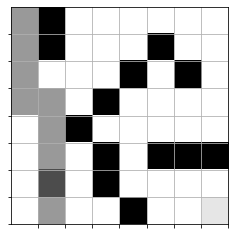

In [99]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

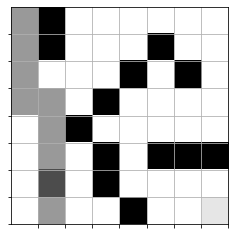

In [100]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.